# Evaluation of the unmasked face detection pipeline

In this notebook we evaluate the combination of the face detector and mask/no_mask classifier.  

For each image in the validation/test set, we do the following:  
  1. Fetch the cropped faces that are the result of the RetinaFace face detector (see face-detection-evaluation.ipynb)
  2. Apply the classification model to these cropped faces to obtain a mask/no_mask prediction
  3. Match the detected faces with the ground truth ones and compare the predicted label to the ground truth label.
     A predicted face bounding box matches a ground truth bounding box if their intersection over union (IoU) > 0.5.  
  
Based on these matched ground truth labels and predictions, we can compute performance statistics (confusion matrix, ROC, etc).

## Imports

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import preprocess_input

import tensorflow as tf 

from sklearn import metrics 
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import itertools
import random
from collections import namedtuple
import os

## Setup

In [2]:
target_size = (112,112)

root_dir = os.path.dirname(os.path.abspath(os.curdir))
data_dir = Path(root_dir) / 'data'

model_dir = data_dir / 'classifier_model_weights'
model_dir.mkdir(exist_ok=True)

real_validation_dir = data_dir / 'validation' / 'real'
real_test_dir = data_dir / 'test'

# ROC curves will be stored here
performance_plots_dir = Path('img')
performance_plots_dir.mkdir(exist_ok=True)

# plots that compare pipeline predictions to ground truth will be stored here
prediction_plot_dir = Path('data_dir/overall_model_evaluation/predictions')
plot_dir_correct = prediction_plot_dir / 'all_correct'
plot_dir_correct.mkdir(exist_ok=True, parents=True)
plot_dir_mistake = prediction_plot_dir / 'mistake'
plot_dir_mistake.mkdir(exist_ok=True, parents=True)

## Create validation and test generators

We set up a validation generator and test generator for real masked and unmasked data. 
The input images to the mask/no_mask classifier are the output of the face detector (generated previously in face_detection.ipynb).

In [3]:
metadata = pd.read_csv(data_dir / 'test_validation_metadata.csv')

In [4]:
# we need both the ground truth and detector bounding boxes to evaluate the IoU 
detector_bboxes = pd.read_csv(data_dir / 'detector_annotations.csv')
ground_truth_boxes = pd.read_csv(data_dir / 'test_validation_metadata.csv')
ground_truth_boxes['img_name'] = ground_truth_boxes.raw_img_dir.apply(lambda x: Path(x).name)

In [5]:
val_frame_real = pd.DataFrame(columns=['original_image','bbox_id','x','y','w','h','class','image'])

for row_idx, row in metadata.iterrows():
    if not 'validation' in row.cropped_img_dir:
        continue
    fn = Path(row.cropped_img_dir).name
    detector_bboxes_fn = detector_bboxes[detector_bboxes.img == fn]
    for d_idx, d_row in detector_bboxes_fn.iterrows():
        val_frame_real.loc[len(val_frame_real)] = [fn,d_row.bbox_id,d_row.x, d_row.y, d_row.w, d_row.h, 'none', d_row.crop_fn]

In [6]:
test_frame_real = pd.DataFrame(columns=['original_image','bbox_id','x','y','w','h','class','image'])

for row_idx, row in metadata.iterrows():
    if not 'test' in row.cropped_img_dir:
        continue
    fn = Path(row.cropped_img_dir).name
    detector_bboxes_fn = detector_bboxes[detector_bboxes.img == fn]
    for d_idx, d_row in detector_bboxes_fn.iterrows():
        test_frame_real.loc[len(test_frame_real)] = [fn,d_row.bbox_id,d_row.x, d_row.y, d_row.w, d_row.h, 'none', d_row.crop_fn]

In [7]:
val_datagen_real = ImageDataGenerator(preprocessing_function=preprocess_input)
val_frame_real.image = val_frame_real.image.astype(str)
val_generator_real = val_datagen_real.flow_from_dataframe(val_frame_real, 
                                                shuffle=False,
                                                target_size=target_size,
                                                x_col='image')

Found 265 validated image filenames belonging to 1 classes.


In [8]:
test_datagen_real = ImageDataGenerator(preprocessing_function=preprocess_input)
test_frame_real.image = test_frame_real.image.astype(str)
test_generator_real = test_datagen_real.flow_from_dataframe(test_frame_real, 
                                                shuffle=False,
                                                target_size=target_size,
                                                x_col='image')

Found 246 validated image filenames belonging to 1 classes.


## Evaluation code

The functions below implement the evaluation process outlined at the top of this notebook (i.e. matching detector bounding boxes to ground truth and computing statistics).

In [9]:
def bb_intersection_over_union(boxA, boxB):
    """
    Computes the IoU between two bounding boxes
    from https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [10]:
def match_gt_box_with_pred_one_image(gt_box, pred_boxes, pred_scores, iou_threshold=0.5):
    matches = []
    for pred_box, pred_score in zip(pred_boxes, pred_scores): 
        iou = bb_intersection_over_union(gt_box, pred_box)
        if iou > 0.5:
            matches.append(pred_score)
    return matches

def match_gt_boxes_with_pred_boxes(gt_boxes, gt_labels, pred_boxes, pred_scores):
    matched_gt = []
    matched_pred = []
    
    for gt_box, gt_label in zip(gt_boxes, gt_labels):
        matched_gt.append(gt_label)
        matched_scores = match_gt_box_with_pred_one_image(gt_box, pred_boxes, pred_scores)
        if len(matched_scores) == 0:
            # this face is not found by the detector
            matched_pred.append(None)
        elif len(matched_scores) == 1:
            matched_pred.append(matched_scores[0])
        else:
            # there are multiple predictions, we take the lowest value (if there's an unmasked face, we definitely want to predict it)
            # not that this happens very rarely
            matched_pred.append(min(matched_scores)) 
        
    return matched_gt, matched_pred

def count_pred_boxes_that_dont_match_gt(gt_boxes, pred_boxes):
    n_not_found = 0
    for pred_box in pred_boxes:
        found = False
        for gt_box in gt_boxes:
            if bb_intersection_over_union(gt_box, pred_box) > 0.5:
                found = True
                break
        if not found:
            n_not_found += 1
    return n_not_found

In [11]:
def plot_img(fn, true_boxes, true_labels, pred_boxes, pred_labels):
    """
    Plot the results of the face detector and mask/no_mask classifier as well as ground-truth face boxes.
    
    Keyword arguments:
    fn -- path to the image for which predictions are made
    true_boxes -- ground-truth face bounding boxes
    true_label -- ground-truth labels
    pred_boxes -- bounding boxes produced by face detector
    pred_labels -- predictions made by mask/no_mask classifier for bounding boxes produced by face detector
    """
    img = cv2.imread(str(fn))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure()
    plt.imshow(img/255)
    
    for x1, y1, x2, y2 in true_boxes:
        rect = plt.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=3,edgecolor='black',facecolor='none')
        plt.gca().add_patch(rect)
        
    for (x1, y1, x2, y2), predicted_mask in zip(pred_boxes, pred_labels):
        rect = plt.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=3, edgecolor='green' if predicted_mask else 'red',facecolor='none')
        plt.gca().add_patch(rect)
   
    output_dir = plot_dir_correct if true_labels == pred_labels else plot_dir_mistake
    plt.axis('off')
    plt.savefig(output_dir / fn.name, bbox_inches='tight', pad_inches=0)
    plt.close()

In [12]:
def compute_validation_statistics(model, val_gen, val_df, plot=False, include_missed=False, classification_threshold=0.5):
    """
    Apply a model to the validation data (generated by val_gen and described in more detail in val_df) and print performance statistics.
    Also returns matched ground truth labels and pipeline prediction scores.
    
    
    Keyword arguments:
    model -- the model to evaluate
    val_gen -- generates the validation data
    val_df -- should give additional info on validation data
    plot -- if this is True an image will be produced in prediction_plot_dir with ground truth bounding boxes,
            as well as predicted bounding boxes
    include_missed -- whether to include faces that are missed by the face detector in the returned matched labels and predictions
          use False if you only want to evaluate the mask/no_mask classifier
          use True if you want to evaluate the detector + classifier,
          in this case we will simply predict 1 (i.e. masked) for each face that is not found
    classification_threshold -- predictions > this threshold are classified as masked
    """
    
    pred = model.predict_generator(val_gen)
    
    # prepare the prediction dataframe for merging with val_df
    pred_df = pd.DataFrame({'img' : val_gen.filenames,
                            'pred' : np.squeeze(pred)})
    
    # from the cropped img name (e.g. 100_0.jpg) to the original image name (e.g. 100.jpg)
    pred_df['original_image'] = pred_df.img.apply(lambda x: x.split('/')[-1].split('_')[0] + '.jpg') 
    
    # extract the bbox id, e.g. cropped image 100_0.jpg corresponds to 0th extracted face bbox
    pred_df['bbox_id'] = pred_df.img.apply(lambda x: int(x.split('/')[-1].split('_')[1].split('.')[0]))

    # merging with val_df to get one dataframe with both the class predictions and detector bounding box coordinates
    pred_df = pred_df.merge(val_df, left_on=['original_image', 'bbox_id'], right_on=['original_image', 'bbox_id'])
    
    
    # loop over all the validation images to compare ground-truth bounding boxes
    # to predicted ones in that image
    matched_gt = []
    matched_pred = []
    
    n_detector_boxes_not_found = 0

    val_img_ids = set(val_df.original_image)
    for val_img_id in val_img_ids:
        
        # first collect ground truth bounding boxes and labels in a nicer format
        img_ground_truth = ground_truth_boxes[ground_truth_boxes.img_name == val_img_id]
        true_labels = []
        true_boxes = []
        for idx, row in img_ground_truth.iterrows():
            true_labels.append(1 if row['class'] == 'masked' else 0)
            true_boxes.append((row.x, row.y, row.x + row.w, row.y + row.h))

        # do the same for the predictions
        img_pred = pred_df[pred_df.original_image == val_img_id]
        pred_labels = []
        pred_boxes = []
        pred_scores = []
        for idx, row in img_pred.iterrows():
            pred_boxes.append((row.x, row.y, row.x + row.w, row.y + row.h))
            pred_scores.append(row.pred)
            
        if plot:
            plot_img(data_dir / 'raw_images' / val_img_id, true_boxes, true_labels, pred_boxes, [x > 0.5 for x in pred_scores])
       
        cur_matched_gt, cur_matched_pred = match_gt_boxes_with_pred_boxes(true_boxes, true_labels, pred_boxes, pred_scores)
        matched_gt.extend(cur_matched_gt)
        matched_pred.extend(cur_matched_pred)
        
        n_detector_boxes_not_found += count_pred_boxes_that_dont_match_gt(true_boxes, pred_boxes)
        
    return matched_gt, matched_pred, n_detector_boxes_not_found

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Load model

In [14]:
best_model = tf.keras.models.load_model(model_dir / 'best.h5')

## Evaluate on the validation set (only the part with real data)

In [15]:
matched_gt, matched_scores, n_detector_boxes_not_found = compute_validation_statistics(best_model,val_generator_real, val_frame_real, plot=False)

Instructions for updating:
Please use Model.predict, which supports generators.


In [16]:
print(f"{matched_scores.count(None)} ground truth face annotations were not detected by the face detector")
print(f"{n_detector_boxes_not_found} boxes that were found by the face detector were not in the ground truth")

11 ground truth face annotations were not detected by the face detector
9 boxes that were found by the face detector were not in the ground truth


In [17]:
matched_gt_not_none = [x for x,y in zip(matched_gt, matched_scores) if y is not None]
matched_scores_not_none = [x for x in matched_scores if x is not None]
matched_pred_not_none = [x > 0.5 for x in matched_scores_not_none]

matched_scores_none_replaced = [1 if x is None else x for x in matched_scores]
matched_pred_none_replaced = [x > 0.5 for x in matched_scores_none_replaced]

In [18]:
print(f"The accuracy of the mask/no_mask classifier on the ground-truth faces that have been detected by the detector: {metrics.accuracy_score(matched_gt_not_none,matched_pred_not_none):.2f}" )

The accuracy of the mask/no_mask classifier on the ground-truth faces that have been detected by the detector: 0.93


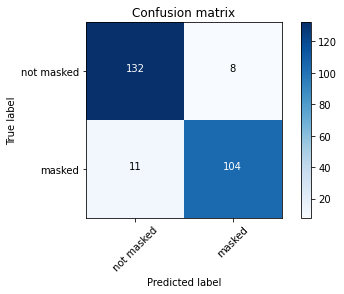

In [19]:
cm = metrics.confusion_matrix(matched_gt_not_none, matched_pred_not_none)
plot_confusion_matrix(cm, ['not masked', 'masked'])

Text(0.5, 1.0, 'ROC for complete pipeline\nAUC = 0.933')

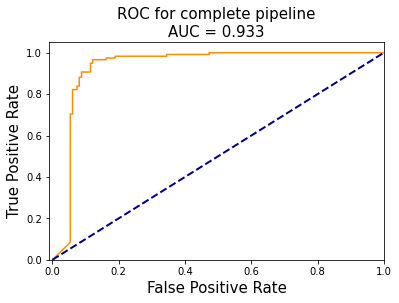

In [20]:
fpr, tpr, thr = metrics.roc_curve(matched_gt, matched_scores_none_replaced)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title(f'ROC for complete pipeline\nAUC = {auc:.3f}', size=15)

## Evaluation on the test set

In [21]:
matched_gt, matched_scores, n_detector_boxes_not_found = compute_validation_statistics(best_model, test_generator_real, test_frame_real, plot=True)

In [22]:
print(f"{matched_scores.count(None)} ground truth face annotations were not detected by the face detector")
print(f"{n_detector_boxes_not_found} boxes that were found by the face detector were not in the ground truth")

18 ground truth face annotations were not detected by the face detector
15 boxes that were found by the face detector were not in the ground truth


In [23]:
matched_gt_not_none = [x for x,y in zip(matched_gt, matched_scores) if y is not None]
matched_scores_not_none = [x for x in matched_scores if x is not None]
matched_pred_not_none = [x > 0.5 for x in matched_scores_not_none]

matched_scores_none_replaced = [1 if x is None else x for x in matched_scores]
matched_pred_none_replaced = [x > 0.5 for x in matched_scores_none_replaced]

In [24]:
print(f"The accuracy of the mask/no_mask classifier on the ground-truth faces that have been detected by the detector: {metrics.accuracy_score(matched_gt_not_none,matched_pred_not_none):.2f}" )

The accuracy of the mask/no_mask classifier on the ground-truth faces that have been detected by the detector: 0.91


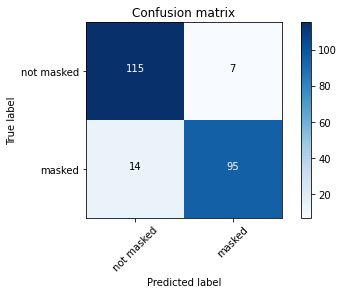

In [25]:
cm = metrics.confusion_matrix(matched_gt_not_none, matched_pred_not_none)
plot_confusion_matrix(cm, ['not masked', 'masked'])

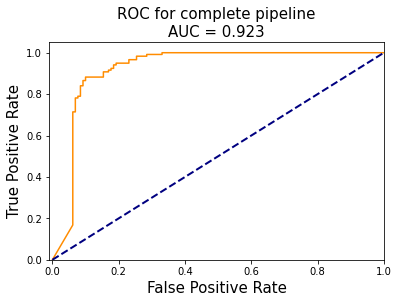

In [26]:
fpr, tpr, thr = metrics.roc_curve(matched_gt, matched_scores_none_replaced)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title(f'ROC for complete pipeline\nAUC = {auc:.3f}', size=15)
plt.savefig(performance_plots_dir / 'roc_complete.png', bbox_inches='tight', pad_inches=0)

## Plot some examples

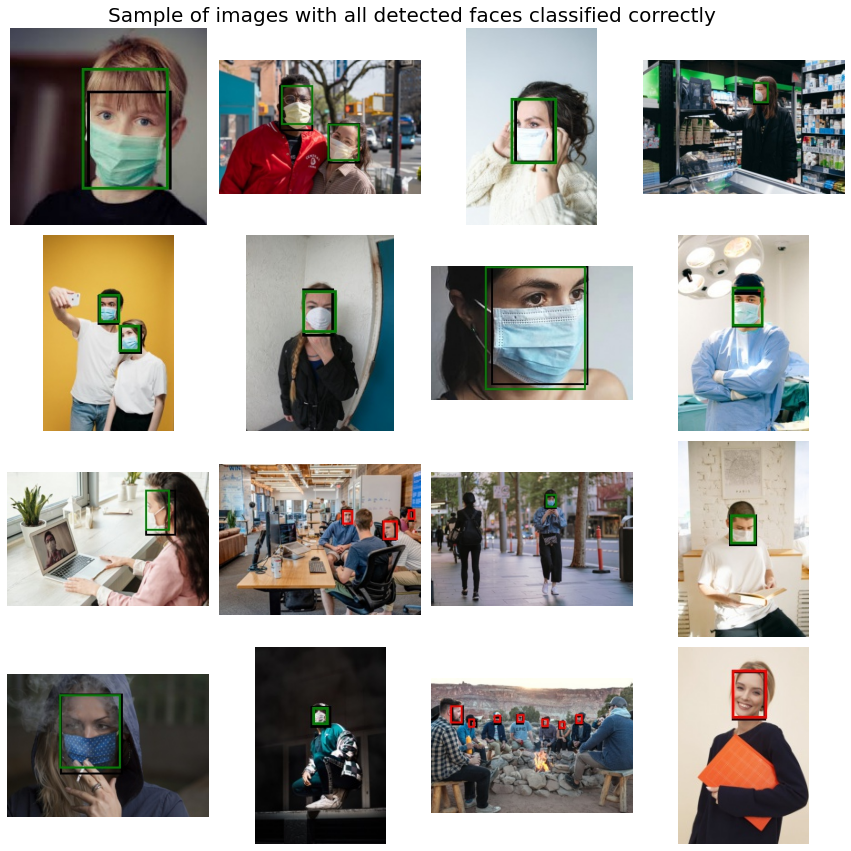

In [27]:
n_to_plot = 16
all_correct_pred = list(plot_dir_correct.glob('*.jpg'))
to_plot = random.sample(all_correct_pred,n_to_plot)

nrow = np.ceil(np.sqrt(n_to_plot))
ncol = nrow

plt.figure(figsize=(15,15))
for idx, x in enumerate(to_plot):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(str(x))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample of images with all detected faces classified correctly', size=20, y=0.9)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

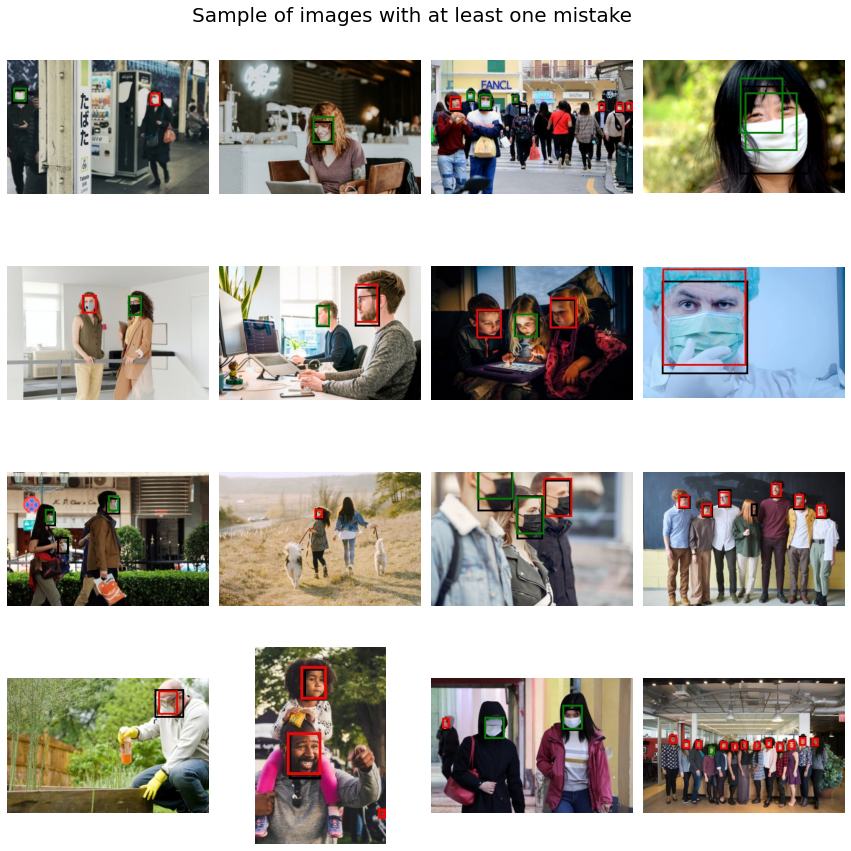

In [28]:
n_to_plot = 16
all_mistake_pred = list(plot_dir_mistake.glob('*.jpg'))
to_plot = random.sample(all_mistake_pred,n_to_plot)

nrow = np.ceil(np.sqrt(n_to_plot))
ncol = nrow

plt.figure(figsize=(15,15))
for idx, x in enumerate(to_plot):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(str(x))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample of images with at least one mistake', size=20, y=0.9)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()